# Brain Tumor Detection Using EfficientNet Model

## 1.0 Project Overview and Objectives

The main purpose of this project was to build a Convolutional Neural Network (CNN) model to perform classification on brain images captured using MRI to detect brain tumor. The dataset consists of 155 images with brain tumor (designated here as __1__) and 98 images without brain tumor (designated here as __0__) and these images are split into three different sets: training, validation ans test sets.

The purpose of each set:
 - __Training:__ It is used to train the model
 - __Validation:__ It is used to tune the model's hyperparameters
 - __Test:__ It is used to check the model's performance after training

### 1.1 What is a brain tumor?

A brain tumor is a collection of abnormal cells in the brain and they can be __malignant__ or __benign__. When benign or malignant tumors grow, they can cause the pressure inside the skull to increase, which will cause brain damage and can be life-threatening. Brain tumors are categorized as primary or secondary:
- __Primary:__ Originates in the brain and most of them are benign
- __Secondary:__ Also known as metastatic brain tumor, occurs when cancer cells spread to the brain from another organ such as lung or breast

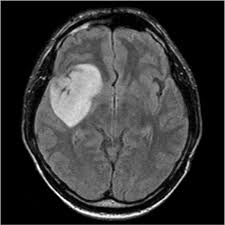

The above image is an example of a brain tumor present in the brain.

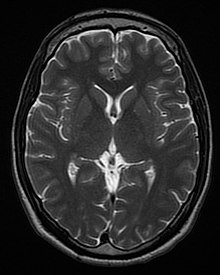

The above image is an example of a brain tumor absent in the brain.

## 2.0 Setting Up the Environment and Import Libraries

Setting up the path directory so the images can be accessed easily and import important libraries such as pandas, matplotlib, PyTorch etc to later split the images, pre-process the images, train the CNN model and evaluate the model.

In [13]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pandas as pd
import numpy as np
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from PIL import Image
import random
import gc
import fnmatch

%matplotlib inline

In [14]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [15]:
torch.cuda.empty_cache()
gc.collect()

24

In [16]:
torch.cuda.is_available()

True

In [17]:
no_images_path = glob("C:/Users/rafen/Documents/Python Programming (Jupyter Notebook)/brain_tumor_dataset/no")
no_images_path

['C:/Users/rafen/Documents/Python Programming (Jupyter Notebook)/brain_tumor_dataset/no']

In [18]:
yes_images_path = glob("C:/Users/rafen/Documents/Python Programming (Jupyter Notebook)/brain_tumor_dataset/yes")
yes_images_path

['C:/Users/rafen/Documents/Python Programming (Jupyter Notebook)/brain_tumor_dataset/yes']

In [19]:
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transforms = None):
        self.root_dir = root_dir
        self.transforms = transforms
        self.filenames = fnmatch.filter(os.listdir(list(self.root_dir)[0]), '*.*')

    def __len__(self):
        return len(self.filenames)

    def crop_images(self, img):
        #canny_edge = cv2.Canny(img, 0, 150)
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        thres, binary = cv2.threshold(img, 25, 255, cv2.THRESH_BINARY)
        contours, hierarchy = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        sorted_contours = sorted(contours, key = cv2.contourArea, reverse = True)
        outer_contour = sorted_contours[0]
        x, y, w, h = cv2.boundingRect(outer_contour)
        cropped_img = img[y:y + h + 10, x:x + w + 1]
        # img_with_contour = cv2.drawContours(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB), [outer_contour], 0, (255, 0, 0), 2)

        # plt.axis("off")
        # plt.imshow(img_with_contour)
        # plt.show()
        return cropped_img

    def __getitem__(self, index):
        img_class = str(list(self.root_dir)[0]).split('/')[-1]
        y_label = 0 if img_class == "no" else 1
        try:
            img_path = os.path.join(''.join(self.root_dir), self.filenames[index])
            img = Image.open(img_path)
        except (FileNotFoundError, TypeError, IndexError):
            print("Image does not exist.")
            return None

        img = np.array(img)
        img = self.crop_images(img)
        img = torch.from_numpy(np.asarray(img))
        if self.transforms:
            img = self.transforms(img)

        return img, y_label

In [20]:
no_brain_tumor_dataset = BrainTumorDataset(no_images_path, None)
no_brain_tumor_dataset.__getitem__(0)

(tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8),
 0)

In [21]:
no_brain_tumor_dataset

In [22]:
yes_brain_tumor_dataset = BrainTumorDataset(yes_images_path, None)
yes_brain_tumor_dataset.__getitem__(0)

(tensor([[4, 0, 0,  ..., 2, 2, 2],
         [4, 0, 0,  ..., 2, 2, 2],
         [5, 0, 1,  ..., 2, 2, 2],
         ...,
         [2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2]], dtype=torch.uint8),
 1)

In [23]:
yes_brain_tumor_dataset

## 3.0 Data Visualization, Pre-processing and Augmentation

In [25]:
from pathlib import Path

def plot_sample_img(dataset, directory, tumor_presence):
    c = 0
    ncol = 10
    nrow = int(len(dataset)/ncol) + 1

    for i in range(1, nrow + 1):
        plt.figure(figsize = (15, 15))
        if c == 0: 
            plt.suptitle("Tumor: {}".format(str(tumor_presence)))
        for j in range(1, ncol + 1):
            if c == len(dataset):
                break
            plt.subplot(nrow, ncol, j)
            plt.imshow(dataset.__getitem__(c)[0], cmap = 'gray')
            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.show()

Display all the images with and without brain tumor to better understand how do they look like.

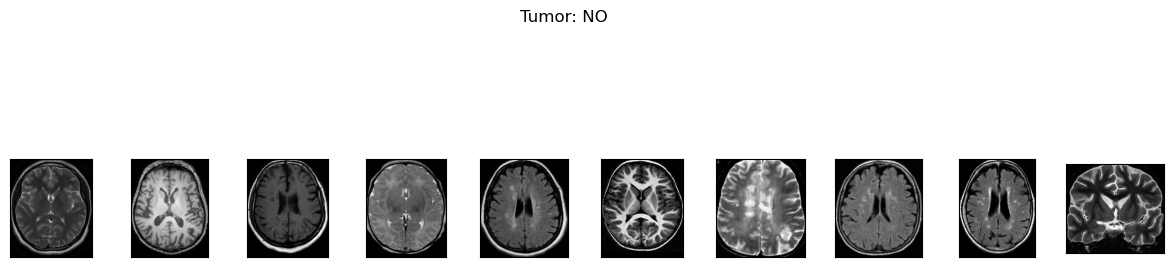

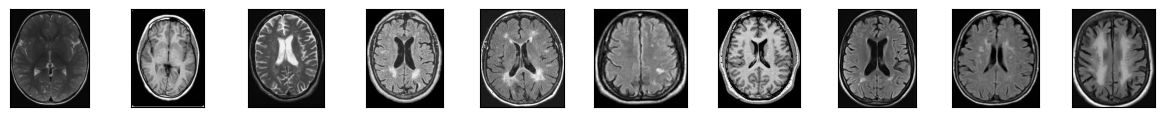

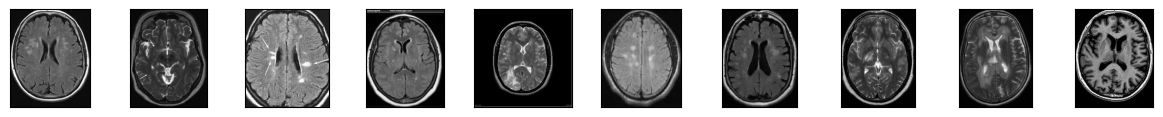

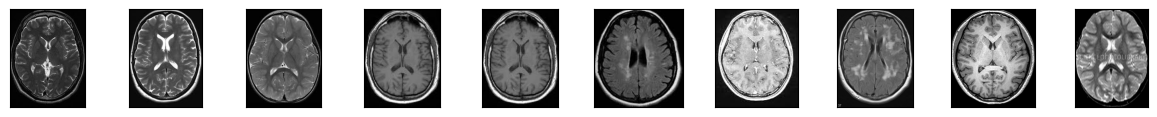

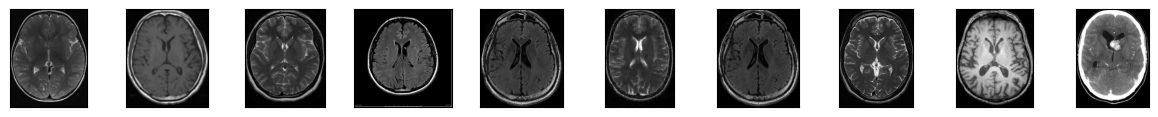

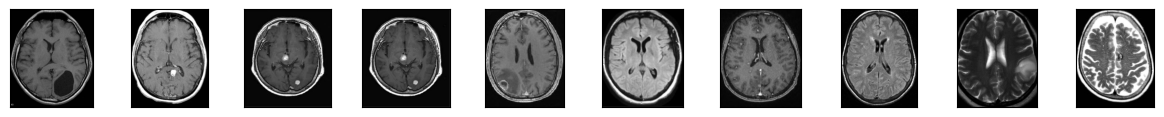

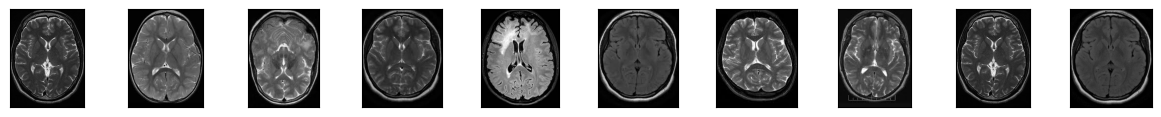

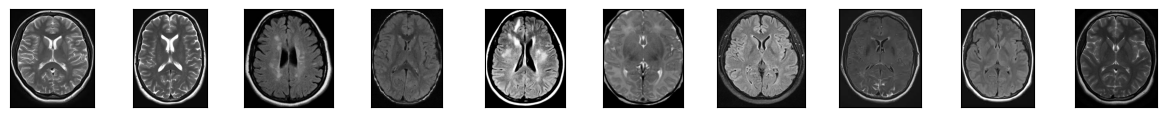

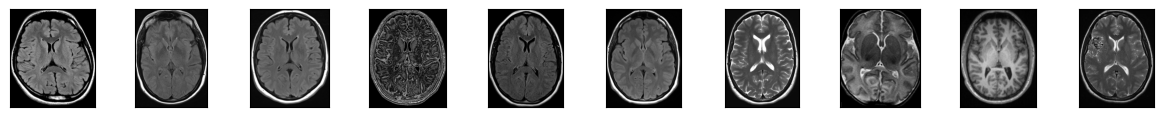

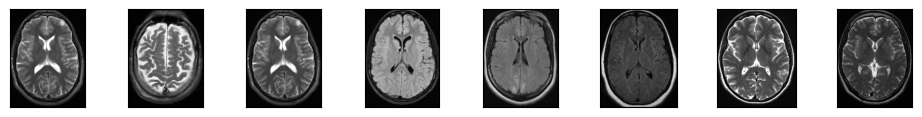

In [27]:
plot_sample_img(no_brain_tumor_dataset, no_images_path, "NO")

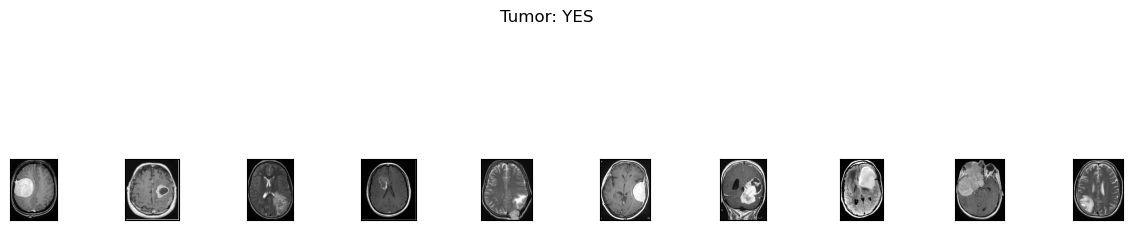

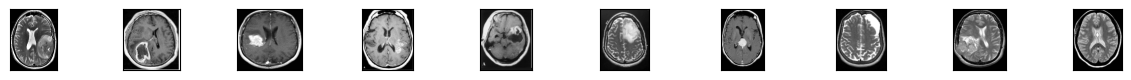

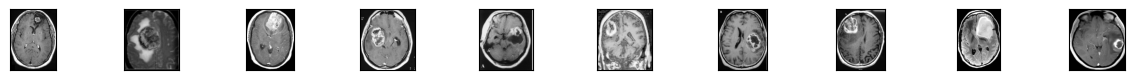

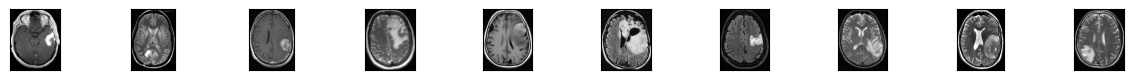

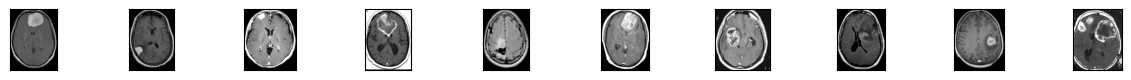

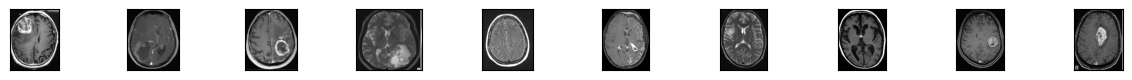

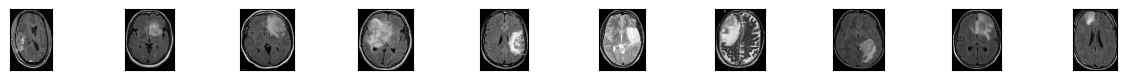

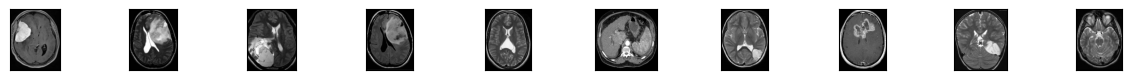

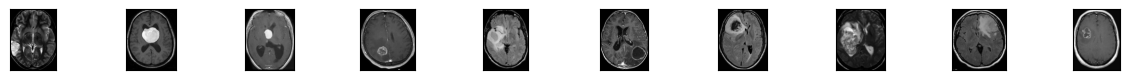

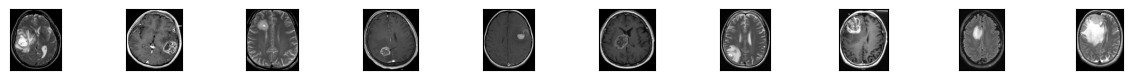

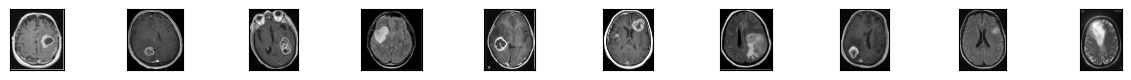

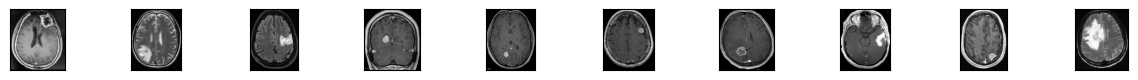

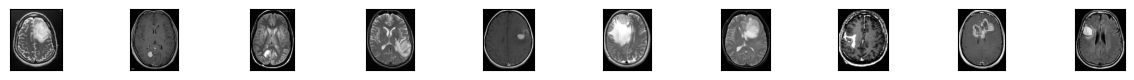

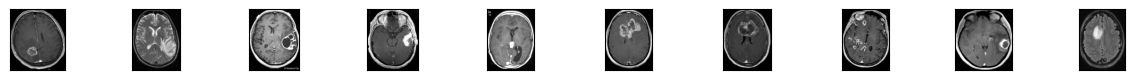

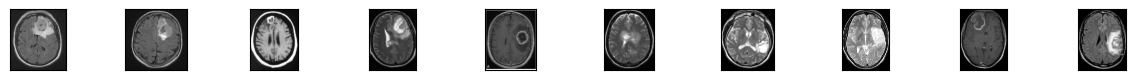

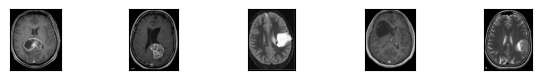

In [28]:
plot_sample_img(yes_brain_tumor_dataset, yes_images_path, "YES")

Plot the bar graphs to see the number of images with and without the presence of brain tumor. The split the images into train, validation and test sets and plot a bar graph to see the number of images in each set.

First, the original dataset is split into 80% training data and 20% test data. Then from the training set, it is split further into 80% training data and 20& validation data.

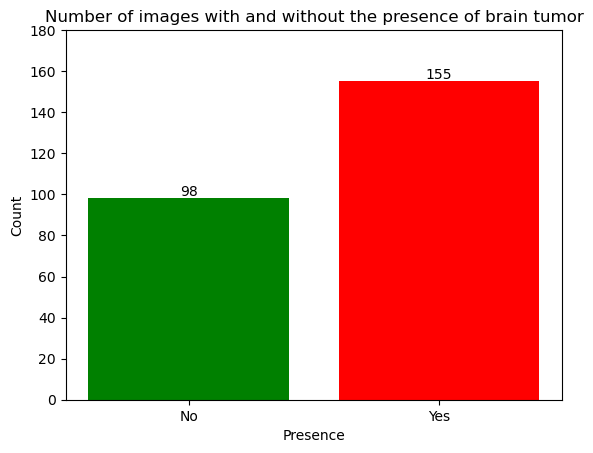

In [30]:
brain_tumor_presence = ["No", "Yes"]
count = [len(no_brain_tumor_dataset), len(yes_brain_tumor_dataset)]

plt.bar(brain_tumor_presence, count, color = ['green', 'red'])
plt.title("Number of images with and without the presence of brain tumor")
plt.ylim(0, 180)
plt.xlabel("Presence")
plt.ylabel("Count")

for index, value in enumerate(count):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.show()

In [31]:
brain_tumor_dataset = torch.utils.data.ConcatDataset([no_brain_tumor_dataset, yes_brain_tumor_dataset])
len(brain_tumor_dataset)

253

In [32]:
# Set seed
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

# def set_seed(seed=42):
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)  # For multi-GPU
#     np.random.seed(seed)
#     random.seed(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False

set_seed(42)

train_set, test_set = random_split(brain_tumor_dataset, [0.8, 0.2])
train_set, val_set = random_split(train_set, [0.8, 0.2])
len(train_set), len(val_set), len(test_set)

(163, 40, 50)

In [33]:
from collections import Counter

def count_labels(dataset):
    """Count occurrences of each y_label in the dataset."""
    label_counter = Counter()
    for i in range(len(dataset)):
        try:
            _, label = dataset[i]  # Get the image and label
            label_counter[label] += 1
        except TypeError:
            # Skip NoneType returns from __getitem__
            continue
    return label_counter

In [34]:
count_labels(train_set), count_labels(val_set), count_labels(test_set)

(Counter({1: 99, 0: 64}), Counter({1: 22, 0: 18}), Counter({1: 34, 0: 16}))

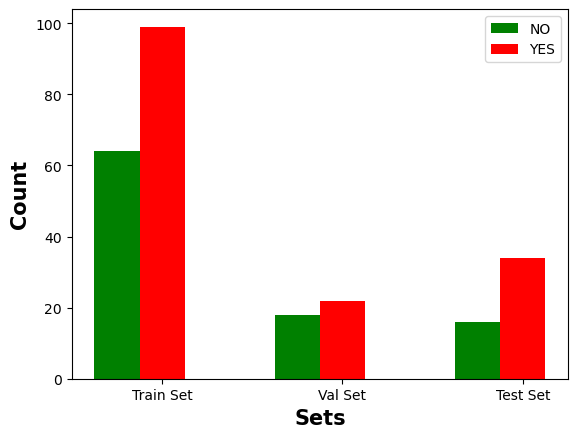

In [35]:
no_count = [count_labels(train_set)[0], count_labels(val_set)[0], count_labels(test_set)[0]]
yes_count = [count_labels(train_set)[1], count_labels(val_set)[1], count_labels(test_set)[1]]

barWidth = 0.25
br1 = np.arange(len(no_count)) 
br2 = [x + barWidth for x in br1]

plt.bar(br1, no_count, color = 'green', width = barWidth, label = 'NO')
plt.bar(br2, yes_count, color = 'red', width = barWidth, label = 'YES')
plt.xlabel('Sets', fontweight ='bold', fontsize = 15) 
plt.ylabel('Count', fontweight ='bold', fontsize = 15) 
plt.xticks([r + barWidth for r in range(len(no_count))], ['Train Set', 'Val Set', 'Test Set'])
plt.legend()
plt.show()

Preprocessing the images before training the model is important as it can manipulate raw image data into meaningful and useful information where unwanted distortions are eliminated and specific essential qaulities are enhanced. The most important pre-processing technique here is __normalization__ as it adjusts the intensity values of the pixels to a desired range, in this case ranging from approximately -2.12 to +2.64 which will improve the model performance.

Both training and validation sets have undergone data augmentation where each image in each set is transformed or modified to increase the diversity and variablility of the data which can help the model generalize better to unseen data and mitigate issues such as overfitting. The images are randomly flipped horizontally or vertically, randomly rotated and the brightness is either decreased or increased.

In [37]:
class preprocess_img(Dataset):
    def __init__(self, dataset, transforms = None):
        self.dataset = dataset
        self.transforms = transforms

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img, y_label = self.dataset[index]
        if self.transforms:
            img = np.array(img)
            img = self.transforms(img)
        return img, y_label

In [38]:
preprocess_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(brightness = (0.75, 1.25), contrast = (0.75, 1.25)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees = 20),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Resize([384, 384]),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [39]:
set_seed(42)
preprocessed_train_set = preprocess_img(train_set, transforms = preprocess_transform)
preprocessed_train_set.__getitem__(0)

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

In [40]:
val_test_preprocess_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Resize([384, 384]),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [41]:
set_seed(42)
preprocessed_val_set = preprocess_img(val_set, transforms = val_test_preprocess_transform)
preprocessed_val_set.__getitem__(0)

(tensor([[[ 0.5707, -0.1950, -1.3790,  ..., -1.0930, -0.2803,  0.2453],
          [ 0.2852, -0.4682, -1.6332,  ..., -1.4350, -0.4815,  0.1350],
          [-0.1563, -0.8907, -2.0263,  ..., -1.9638, -0.7928, -0.0356],
          ...,
          [-0.1662, -0.8725, -1.9648,  ..., -1.9721, -0.7758, -0.0022],
          [ 0.3957, -0.0787, -0.8123,  ..., -0.7658, -0.0339,  0.4393],
          [ 0.7591,  0.4346, -0.0671,  ...,  0.0143,  0.4458,  0.7248]],
 
         [[ 0.7129, -0.0699, -1.2803,  ..., -0.9880, -0.1571,  0.3803],
          [ 0.4210, -0.3492, -1.5402,  ..., -1.3375, -0.3628,  0.2675],
          [-0.0303, -0.7811, -1.9421,  ..., -1.8781, -0.6810,  0.0931],
          ...,
          [-0.0405, -0.7626, -1.8792,  ..., -1.8866, -0.6636,  0.1272],
          [ 0.5340,  0.0490, -0.7010,  ..., -0.6534,  0.0948,  0.5786],
          [ 0.9055,  0.5738,  0.0609,  ...,  0.1441,  0.5852,  0.8704]],
 
         [[ 0.9319,  0.1527, -1.0524,  ..., -0.7613,  0.0659,  0.6008],
          [ 0.6414, -0.1254,

In [42]:
set_seed(42)
preprocessed_test_set = preprocess_img(test_set, transforms = val_test_preprocess_transform)
preprocessed_test_set.__getitem__(0)

(tensor([[[-2.1179, -2.1179, -1.1534,  ...,  2.2410,  0.2361, -2.1179],
          [-2.1179, -2.1179, -1.2796,  ...,  2.2478,  0.2361, -2.1179],
          [-2.1179, -2.0896, -1.4271,  ...,  2.2368,  0.2482, -2.0917],
          ...,
          [-2.1179, -2.1179, -2.1088,  ..., -2.1057, -2.1097, -2.1048],
          [-1.5038, -1.5038, -1.5038,  ..., -1.4931, -1.4959, -1.5038],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2449,  2.2489,  2.2489]],
 
         [[-2.0357, -2.0357, -1.0497,  ...,  2.4205,  0.3708, -2.0357],
          [-2.0357, -2.0357, -1.1787,  ...,  2.4274,  0.3708, -2.0357],
          [-2.0357, -2.0068, -1.3295,  ...,  2.4161,  0.3832, -2.0089],
          ...,
          [-2.0357, -2.0357, -2.0264,  ..., -2.0232, -2.0273, -2.0223],
          [-1.4079, -1.4079, -1.4079,  ..., -1.3969, -1.3998, -1.4079],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4245,  2.4286,  2.4286]],
 
         [[-1.8044, -1.8044, -0.8228,  ...,  2.6319,  0.5914, -1.8044],
          [-1.8044, -1.8044,

## 4.0 Building The CNN Model

In [44]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for img in self.dl:
            yield to_device(img, self.device)

    def __len__(self):
        return len(self.dl)

In [45]:
set_seed(42)

batch_size = 8
num_classes = 2
num_epochs = 30
lr = 1e-3
opt_func = torch.optim.Adam

In [46]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
device

device(type='cuda')

In [47]:
set_seed(42)
train_set_loader = DataLoader(dataset = preprocessed_train_set, batch_size = batch_size, shuffle = True)
val_set_loader = DataLoader(dataset = preprocessed_val_set, batch_size = batch_size, shuffle = True)
test_set_loader = DataLoader(dataset = preprocessed_test_set, batch_size = batch_size, shuffle = True)

In [48]:
set_seed(42)
train_dl = DeviceDataLoader(train_set_loader, device)
val_dl = DeviceDataLoader(val_set_loader, device)
test_dl = DeviceDataLoader(test_set_loader, device)

In [49]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        img, labels = batch
        out = self(img)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'train_loss': loss, 'train_acc': acc}

    def validation_step(self, batch):
        img, labels = batch
        out = self(img)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = torch.stack([x['val_loss'] for x in outputs])
        epoch_loss = batch_losses.mean()
        batch_accs = torch.stack([x['val_acc'] for x in outputs])
        epoch_acc = batch_accs.mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print('Epoch[{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f},'.format(epoch, result['train_loss'], result['train_acc'],
                                                                                                           result['val_loss'], result['val_acc']))

In [50]:
def evaluate(model, val_dl):
    model.eval()
    outputs = []

    with torch.no_grad():
        for batch in val_dl:
            output = model.validation_step(batch)
            outputs.append(output)
    return model.validation_epoch_end(outputs)

In [51]:
class EarlyStopping:
    def __init__(self, patience = 5, min_delta = 0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

### 4.1 Import the EfficientNet Model from PyTorch

EfficientNet is a family of CNNs that aims to achieve high performance with fewer computational resources by uniformly scaling all dimensions of width, depth and resolution using a compound coefficient.

It is found that although scaling a single dimension helps to improve model performance, by balancing the scale in all three dimensions (width, depth, and image resolution) increases overall model performance while taking the changeable available resources into consideration. The componenets of compound scaling are:

- __Depth Scaling:__ Increases the depth or the number of layers of the neural network
- __Width Scaling:__ Increases the width or the number of channels/neurons in each layer
- __Resolution Scaling:__ Increases the resolution of the input image

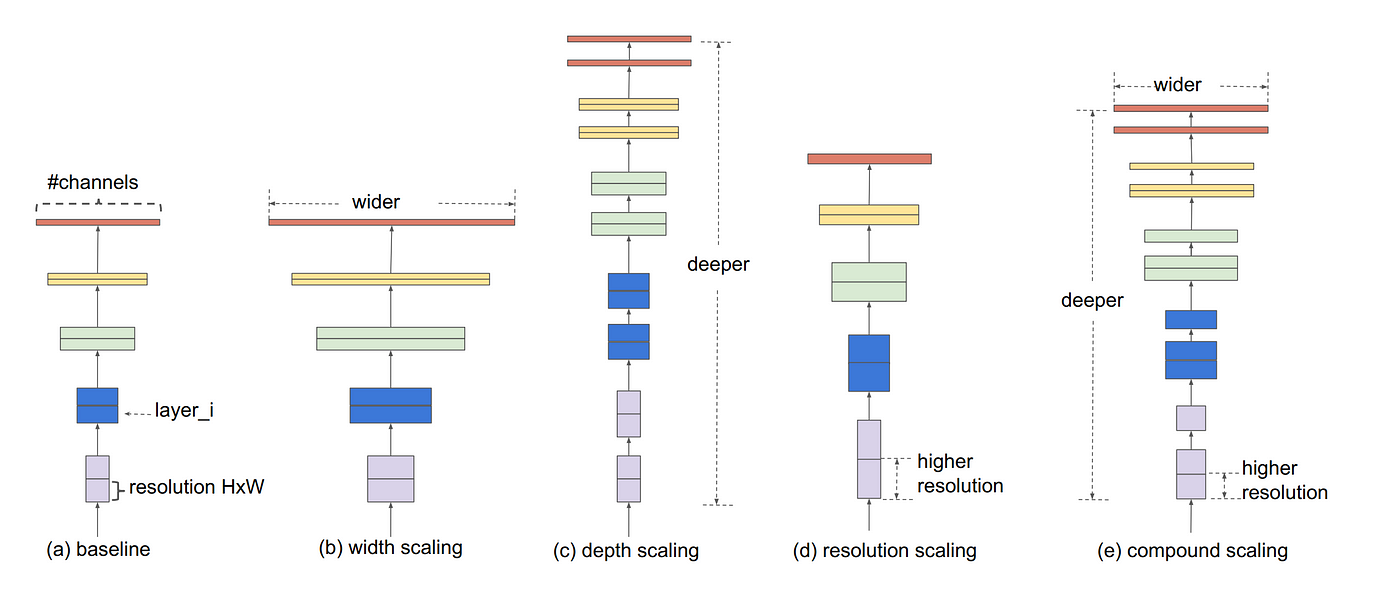

In [55]:
set_seed(42)
efficientNet = models.efficientnet_b4(pretrained = True)

C:\Users\rafen\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\rafen\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [56]:
num_features = efficientNet.classifier[1].in_features
num_features

1792

In [57]:
efficientNet.classifier[1] = nn.Linear(num_features, num_classes)
#efficientNet

In [58]:
class EfficientNetModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = efficientNet

    def forward(self, x):
        return self.network(x)

In [59]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD, patience = 5):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.01, patience = 1, verbose = False)
    early_stopping = EarlyStopping(patience = patience, min_delta = 0.01)

    for epoch in range(epochs):
        model.train()
        train_losses = []
        train_accs = []

        for batch in train_loader:
            loss_dict = model.training_step(batch)
            loss = loss_dict['train_loss']
            acc = loss_dict['train_acc']

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_losses.append(loss.detach())
            train_accs.append(acc.detach())

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accs).mean().item()

        val_loss = result['val_loss']
        scheduler.step(val_loss)
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch}")
            break

        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [60]:
set_seed(42)

efficient_model = EfficientNetModel()
efficient_model = efficient_model.to(device)
#efficient_model

### 4.2 Train the EfficientNet Model

In [ ]:
set_seed(42)
history = fit(num_epochs, lr, efficient_model, train_dl, val_dl, opt_func)

C:\Users\rafen\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch[0], train_loss: 0.6461, train_acc: 0.6190, val_loss: 0.5852, val_acc: 0.8000,
Epoch[1], train_loss: 0.4454, train_acc: 0.8175, val_loss: 0.3164, val_acc: 0.8750,
Epoch[2], train_loss: 0.3178, train_acc: 0.8810, val_loss: 0.2194, val_acc: 0.9250,
Epoch[3], train_loss: 0.1450, train_acc: 0.9702, val_loss: 0.4806, val_acc: 0.8500,
Epoch[4], train_loss: 0.1672, train_acc: 0.9464, val_loss: 0.2295, val_acc: 0.9000,
Epoch[5], train_loss: 0.1152, train_acc: 0.9702, val_loss: 0.2306, val_acc: 0.9000,
Epoch[6], train_loss: 0.0982, train_acc: 0.9643, val_loss: 0.2225, val_acc: 0.9250,


### 4.3 Plot the Training and Validation Accuracies Against Number of Epochs

In [ ]:
def plot_accuracies(history):
    val_acc = [float(x['val_acc']) for x in history]
    train_acc = [float(x['train_acc']) for x in history]
    plt.plot(train_acc, '-bx')
    plt.plot(val_acc, '-rx')
    plt.ylim(0, 1.0)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(['Training', 'Validation'])
    plt.title("Accuracy vs No. of Epochs")
    plt.show()

In [ ]:
plot_accuracies(history)

### 4.4 Plot the Training and Validation Losses Against Number of Epochs

In [ ]:
def plot_losses(history):
    val_acc = [float(x['val_loss']) for x in history]
    train_acc = [float(x['train_loss']) for x in history]
    plt.plot(train_acc, '-bx')
    plt.plot(val_acc, '-rx')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(['Training', 'Validation'])
    plt.title("Loss vs No. of Epochs")
    plt.show()

In [ ]:
plot_losses(history)

## 5.0 Model Evaluation

### 5.1 Evaluate the Trained Model, Plot the Confusion Matrix and Display the Classification Report

Confusion matrix shows how well a classification model is performing by comparing its predictions to actual results. There are four categories in a confusion matrix: correct predictions (true positives and negatives) for both classes and incorrect predictions (false positives and negatives) for both class.

- __True Positive (TP):__ The correctly predicted positive outcome (the actual outcome was positive)
- __True Negative (TN):__ The correctly predicted negative outcome (the actual outcome was negative)
- __False Positive (FP) / Type I Error:__ The incorrectly predicted positive outcome (the actual outcome was negative)
- __False Negative (FN) / Type II Error:__ The incorrectly predicted negative outcome (the actual outcome was positive)

A confusion matrix can help calculate the classification metrics such as accuracy, precision and recall, which provides better idea of the model performance when the data is imbalanced.

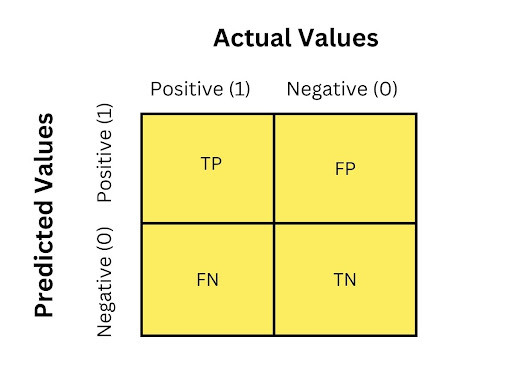

In [ ]:
def evaluate_model(model, test_loader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for img, label in test_loader:
            img, label = img.to(device), label.to(device)
            outputs = model(img)
            _, preds = torch.max(outputs, 1)
            y_true.extend(label.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    conf_matrix = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(conf_matrix)

    plt.figure(figsize = (8, 8))
    sns.heatmap(conf_matrix, cmap = 'Blues', annot = True, fmt = 'd', xticklabels = True, yticklabels = True)
    plt.title("Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Prediction")

    report = classification_report(y_true, y_pred, target_names = ["NO", "YES"])
    print("\nClassification Report:")
    print(report)

classification_report from sklearn.metrics is used to build a text report to show the main classification metrics such as accuracy, precision, recall and F1 score for each class.

- __Accuracy:__ Measures how often the classifier correctly predicts, it is the ratio of the number of correct predictions and the total number of predictions

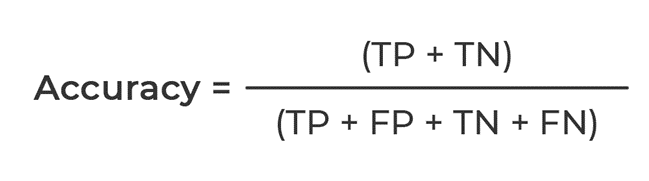

- __Precision:__ How many of the correctly predicted cases actually turned out to be positive, it is the ratio of the number of true positives and the number of predicted positives

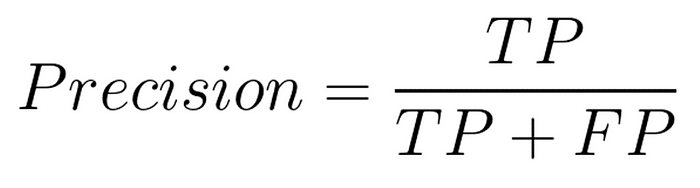

- __Recall:__ How many of the actual positive cases were able to be predicted correctly with the model, it is the ratio of the number of true positives and the total number of actual positives

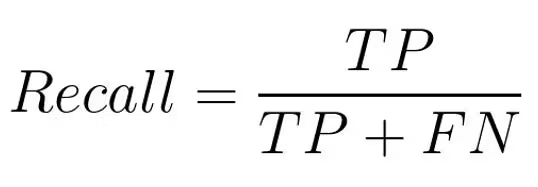

- __F1 Score:__ A combination of precision and recall metrics, it is maximum when precision is equal to recall

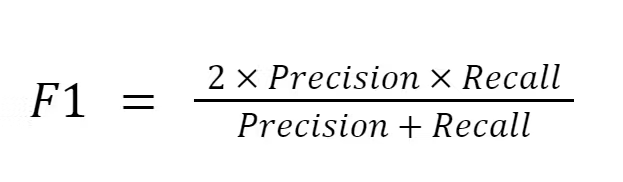

In [ ]:
set_seed(42)
evaluate_model(efficient_model, test_dl, device)

Since the dataset is imbalanced, using accuracy as the main metric will provide false interpretation of the model. Hence, recall will be used as the main classification metric as it is best to reduce false negatives or Type II error from occurring where patients with brain tumor are diagnosed as tumor-free.

### 5.2 Plot the Heatmap using Grad-CAM (Gradient-Weight Class Activation Mapping)

Grad-CAM is a technique used in deep learning, particularly with convolutional neural network (CNN) to understand which regions of an input image are important for the model's prediction of a certain class. The reasons for using Grad-CAM are:

- Retains the architecture of the model while offering interpretability without compromising accuracy
- Generates visual explanations for CNN-based networks without architectural changes or re-training

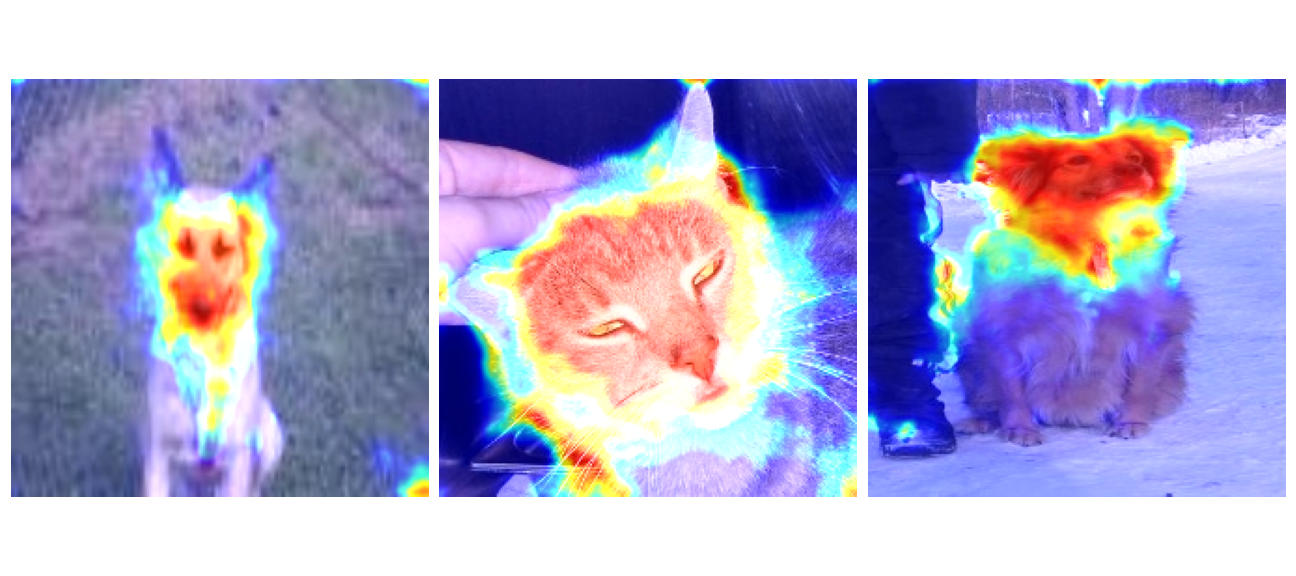

In [ ]:
set_seed(42)

target_layer = efficient_model.network.features[-1]
cam = GradCAM(model = efficient_model, target_layers = target_layer)

j = 0
for batch in test_dl:
    j += 1
    img, labels = batch
    plt.figure(figsize = (45, 30))
    for i in range(len(img)):
        output = efficient_model(img[i].unsqueeze(0))
        pred_class = output.argmax().item()
        grayscale_img = cam(img[i].unsqueeze(0))
        grayscale_img = torch.from_numpy(grayscale_img)
        grayscale_img = grayscale_img.permute(1, 2, 0)
        grayscale_img = grayscale_img.expand(384, 384, 3).clone()
        grayscale_img = grayscale_img.permute(0, 1, 2)
        grayscale_img = 1 - grayscale_img
        grayscale_img /= torch.max(grayscale_img)

        color_img = np.uint8(255 * grayscale_img)
        color_img = cv2.applyColorMap(color_img, cv2.COLORMAP_JET)
        color_img = np.transpose(color_img, (0, 1, 2))
        
        ori_img = img[i].squeeze(0).cpu().numpy()
        ori_img = np.uint8(255 * (ori_img - ori_img.min()) / (ori_img.max() - ori_img.min()))
        ori_img = np.moveaxis(ori_img, 0, -1)
        superimposed_img = cv2.addWeighted(ori_img, 0.6, color_img, 0.4, 0)

        plt.subplot(j, 8, i + 1)
        plt.imshow(superimposed_img)
        plt.title(f"Predicted Class: {pred_class}  Actual Class: {labels[i].cpu().numpy()}", fontsize = 15, fontweight = "bold")
        plt.xticks([])
        plt.yticks([])
    plt.show()

### 5.3 Save the Best Model

In [ ]:
#Save model
torch.save(efficient_model, 'Best_EfficientNet_b4_model_weights.pth')

## 6.0 Conclusion

In conclusion, the model with a recall of __0.97__ is suitable to be deployed to classify whether a brain tumor is present or absent in the patient as chances of the model misclassifying a patient with brain tumor as tumor-free are low. 

### 6.1 Future Improvements

This evalution can be further improved by: 
- Train the model with a balanced dataset containing more images so it can have a better understanding of the features of a tumor
- Test out different convolutional neural network models such as YOLO
- Apply more data augmentation techniques such as add more noises to the images to diversify the data 
- Add a few convolutional layers before the model to extract more features from the images